*AGEC 652 - Spring 2022*

*Unit 2.3 - Function approximation*

# Solving a Cournot oligopoly model with the collocation method

In the standard profit maximization framework, a firm solves

$$\max_q qp(q) - MC(q)$$

In a competitive market where firms are price-takers, $p$ is not affected by a firm's choice of $q$

Thus, the first order condition simply gives $p - MC(q) = 0$

In an oligopoly setting, however, a firm's output can influence the price. The first order condition becomes

$$p + q\frac{dp}{dq} - MC(q) = 0$$

Given standard properties of the demand function $D(p)$, we can use the Inverse Function Theorem to rewrite the FOC as

$$ p + \frac{q}{D^\prime(p)} - MC(q) = 0$$

If we have a specific value for $p$, we can use this expression to calculate the optimal $q$ for this firm

Instead of looking at a specific $p$, we might want to characterize the supply function of this firm, $S(p)$ for any given $p$

We know that $S(p)$ is a function that satisfies

$$ p + \frac{S(p)}{D^\prime(p)} - MC(S(p)) = 0$$

(at least for a range of $p$ where the model supports an interior decision; in most cases, any $p >0$)

If $MC$ and $D$ have simple functional forms, we can solve for $S(p)$ analytically. 

For example: with $MC(q) = c$ and $D(p) = p^{-\eta}$, solve for $S(p)$

$$
p - \frac{S(p)}{\eta p^{-\eta-1}} - c = 0\\
\Rightarrow S(p) = \eta(p-c)p^{-\eta-1}
$$

*(Strictly speaking, we need to impose $q \geq 0$ and write the residual as a complementarity condition. In the $MC = c$ case, we have a kink at $p = c$ and $S(p) = 0$ for $p < c$)*

If we have $m$ identical firms, the equilibrium price satisfies
$$mS(p) = D(p)$$

And, with the simple functional forms above, it yields
$$ p = \left(\frac{1}{1 - \frac{1}{\eta m}} \right)c $$

Note that as $m \rightarrow \infty$, we approach perfect competition: $p = c$

Simple functional forms are nice and can give us insights about the structure of the problem

However, more realistic and less simple functional forms may not yield tractable solution

What do we do instead?

**Numerical methods**

Suppose
$$MC(q) = \alpha q^{1/2} + q^2$$

The FOC becomes
$$
p - \frac{p^{\eta+1}}{\eta}S(p) - \alpha [S(p)]^{1/2} - [S(p)]^2 = 0
$$

and we can't analytically solve for $S(p)$ anymore (though we can confirm that a solution does exist)

We will look for a function $\hat{S}$ that approximates $S$ over some interval $p \in [a, b]$. I.e., we'll use the **collocation method** to solve this functional equation

The original functional equation was
$$
g(p, S(p)) \equiv p - \frac{S(p)}{\eta p^{-\eta-1}} - \alpha [S(p)]^{1/2} - [S(p)]^2 = 0
$$

And we will solve the numerical counterpart
$$
g(p, \hat{S}(p)) \equiv p - \frac{p^{\eta+1}}{\eta}\hat{S}(p) - \alpha [\hat{S}(p)]^{1/2} - [\hat{S}(p)]^2 \approx 0
$$

We will follow through the steps to solve this problem in Julia

First, let's define a specific set of parameters for the model

$$\alpha = 1, \eta = 1.5$$

We will define $\hat{S}(p)$ over the domain $[0.1, 3]$ with a 25-degree Chebyshev polynomial

In [1]:
using ChebyshevApprox, NLsolve;
α = 1.0;
η = 1.5;
a = 0.1;
b = 3.0;
n = 25;

**Q: What do we need next?**

A: We need to define $g$

But let's first get a handle on how the Chebyshev polynomial representation works and write a function for $\hat{f}(x)$

**Write a function** `eval_chebpoly(c, n, a, b, x)` **that receives**
- `c`, a vector of basis coefficients
- `n`, the order of approximation
- `a`, the lower limit of the domain of approximation
- `b`, the upper limit of the domain of approximation
- `x`, a vector of values within the domain of approximation
**and returns a vector with the respective Chebyshev polynomial evaluated at each point in `x`**

Tips if you're stuck:
1. Use `ChebyPoly` to create a polynomial using `c`, `n`, `a`, and `b`
2. Create a vector of the same size of `x`
3. Iterate over the elements of `x` and use `chebyshev_evaluate(my_polynomial, [x[i]])`

Here is one way of doing it

In [2]:
function eval_chebpoly(c, n, a, b, x)
    # Create the Chebyshev polynomial structure
    domain = [b, a] # For God-knows-why, we need to reverse the domain limits
    chebpoly = ChebPoly(c, n, domain) 

    # Initialize y
    y = similar(x)

    # Iterate over x  and calculate y_i = f_hat(x_i)
    for i in 1:length(x)
        y[i] = chebyshev_evaluate(chebpoly, [x[i]])
    end
    return y
end;

Let's test it on some vector of coefficients

In [3]:
some_c = zeros(n);
some_c[2] = 1;

So this Chebyshev polynomial only has the second basis function being non-zero. What is this function?

$\hat{f}(z) = T_1(z) = z$. So this is just the identity function!

In [4]:
eval_chebpoly(some_c, n, a, b, [0.1, 1.0, 3.0])

3-element Vector{Float64}:
 -1.0
 -0.3793103448275862
  1.0

But it's the identity over $z$, so if we evaluate at the bounds, we get $-1$ and $1$.

We will need to evaluate this polynomial over Chebyshev nodes. Let's get them calculated for us

In [5]:
domain = [b, a];
nodes = chebyshev_nodes(n, [b, a])

25-element Vector{Float64}:
 0.1028612437790064
 0.12568348644340155
 0.17096805137202753
 0.23800077392427177
 0.3257245080220783
 0.43275579797510577
 0.5574066964034015
 0.6977113841759138
 0.8514571725525131
 1.016219398607217
 1.1893996636109607
 1.3682668113317586
 1.55
 1.7317331886682414
 1.9106003363890394
 2.083780601392783
 2.248542827447487
 2.4022886158240864
 2.5425933035965986
 2.6672442020248943
 2.774275491977922
 2.8619992260757283
 2.929031948627973
 2.9743165135565985
 2.997138756220994

We are now ready to define our function $g$

**Write function `resid(c, ps)` that**
1. Uses `eval_chebpoly` to evaluate a Chebyshev polynomial at the nodes `ps` and save the results in a vector `S_hat`
2. Calculate and return a vector with the residuals: $ g(p_i, \hat{S}(p_i)) = p_i - \frac{p_i^{\eta+1}}{\eta}\hat{S_i} - \alpha [\hat{S_i}]^{1/2} - [\hat{S_i}]^2$


In [6]:
function resid(c, ps)
    # Evaluate S_hat at each of the p nodes
    S_hat = eval_chebpoly(c, n, a, b, ps)

    # Calculate the residual at each p node
    # (This is our expression for g)
    resid = ps - ps.^(η+1) ./η .* S_hat - α .* sqrt.(S_hat) - (S_hat).^2
end;

What do we do next?

We want to solve this nonlinear rootfinding problem $g(p_i, \hat{S}(p_i, c)) = 0$. So we solve for $c$ using, for example, Newton's method

**We need to define $g(c)$ because `nlsolve` takes single-argument functions only**

In [7]:
 g(c) = resid(c, nodes);

Try running the following commands to solve the problem with a the identity function as the initial guess

In [8]:
c0 = zeros(n);
c0[2] = 1.0;

In [71]:
# solution = NLsolve.nlsolve(g, c0, method=:newton);

## Oh no! What happened?!

In [10]:
solution = NLsolve.nlsolve(g, c0, method=:newton)

LoadError: DomainError with -0.9980267284282714:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

In some iteration, Newton's procedure tried to evaluate $g$ with some negative value of $\hat{S}(p_i)$! 

But that's outside of the domain because $g$ is real-valued and it fails for $[\hat{S}]^{1/2}$

The problem comes from the fact that we are using a polynomial $\hat{S}:[a,b]\rightarrow \mathbb{R}$ but the economic structure imposes $S:\mathbb{R}_{+}\rightarrow\mathbb{R}_{+}$
- We can control the input ($p$) to be positive, but $S$ might be negative as we iterate over vector $c$ when looking for an answer

That's too bad... That means our problem can't be solved? What can we do instead?

We can reframe our approximation so that we are approximating a function that evaluates only to non-negative answers

The easiest (but not necessarily best) option is to just truncate $\hat{f}$: If the price is such that our optimal supply dips into the negative territory, we make it be zero
- That's easy to program!

In [17]:
function resid_truncate_S(c, ps)
    # Evaluate S_hat at each of the p nodes
    S_hat = eval_chebpoly(c, n, a, b, ps)

    # Set to zero any negative supply
    S_hat = max.(S_hat, zeros(length(S_hat)))

    # Calculate the residual at each p node
    resid = ps - ps.^(η+1) ./η .* S_hat - α .* sqrt.(S_hat) - (S_hat).^2
end;
g_truncate_S(c) = resid_truncate_S(c, nodes);

But it comes with a cost: we introduced a kink in our function, so convergence to a solution becomes trickier, especially because the first couple of iterations may have non-monotonic approximations

We can try our luck!

In [18]:
c0 = zeros(n);
solution_trunc = NLsolve.nlsolve(g_truncate_S, c0, method=:newton)

Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 * Zero: [0.2487680785661978, 0.08389156633423217, -0.13964996962662193, 0.04474107126946757, 0.007018039792867559, -0.013523256056633001, 0.007152232614737678, -0.0022952359776403897, 0.0003290964136682467, 0.00022435530682528564, -0.00029096758157173483, 0.00021050684904026958, -0.00010787613720638977, 3.329449317302143e-5, 4.04855617999496e-6, -1.4841074229190063e-5, 1.282654511115316e-5, -7.348415673573333e-6, 2.7459451613071787e-6, -1.3670843953122366e-7, -8.280189048729635e-7, 8.695427479231511e-7, -5.794301038368702e-7, 2.873918790826618e-7, -1.0245588352273355e-7]
 * Inf-norm of residuals: 0.000000
 * Iterations: 6
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 7
 * Jacobian Calls (df/dx): 7

## Yay!

It seems to have worked with an initial guess of zero coefficients. But it might fail for other attempts
- It fails if you start with the identity function

We'll evaluate the quality of this approximation in a bit

There are less drastic approaches than truncation. In general, we want to approximate a function that naturally maps into $\mathbb{R}$

One could use alternative polynomial basis that are non-negative, such as Bernstein polynomials

But a common trick is to use a monotonic transformation like $log$ and $exp$. Let's see how it works

Instead of using a Chebyshev polynomial to approximate $S(p)$, we will approximate $log(S(p))$

Then, we make $\hat{S}_i = exp \left( \widehat{log(S(p_i))} \right)$ 

That means we'll do

In [ ]:
log_S_hat = eval_chebpoly(c, n, a, b, ps)

Then, exponentiate it to get $\hat{S}$

In [ ]:
S_hat = exp.(log_S_hat)

**Go ahead and write a function `resid_log_S(c)` that uses Chebyshev polynomials to approximate** $log(S(p))$

**Then solve for `c` using the Newton's method with a vector of zeros as the initial guess**

In [19]:
function resid_log_S(c, ps)
    # Evaluate S_hat at each of the p nodes
    log_S_hat = eval_chebpoly(c, n, a, b, ps)

    # Chebyshev polynomial actually approximates log(S)
    S_hat = exp.(log_S_hat)

    # Calculate the residual at each p node
    resid = ps - ps.^(η+1) ./η .* S_hat - α .* sqrt.(S_hat) - (S_hat).^2
end;
g_log_S(c) = resid_log_S(c, nodes);

In [20]:
c0 = zeros(n);
solution_log = NLsolve.nlsolve(g_log_S, c0, method=:newton)

Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 * Zero: [-1.681835836864734, 0.8372574388393053, -0.9511379025123776, 0.5344170040956734, -0.2738330186572161, 0.14355489231207016, -0.07777912529626839, 0.04287878074045514, -0.024234335253513126, 0.014373079019670953, -0.009026397268980182, 0.005910419556791698, -0.003935652355467899, 0.0026132689626662937, -0.0017123881293449935, 0.001104456624687495, -0.0007034779038007919, 0.00044570242271886303, -0.00028329985486650456, 0.00018181645638826324, -0.00011788434486895249, 7.65665680374952e-5, -4.872377517878172e-5, 2.8829660981385637e-5, -1.340312012782627e-5]
 * Inf-norm of residuals: 0.000000
 * Iterations: 7
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 8
 * Jacobian Calls (df/dx): 8

Approximating the log of a function also has its drawbacks
- It can't have $S = 0$, so that is not ideal if we care about corner solutions
- The quality of the approximation can vary a lot over the domain: small errors might get bigger once we invert it with `exp`

We can compare our approximations now

One typical way of doing that is to evaluate the residual in a fine grid and calculate the maximum absolute residual

Let's do that!

We start by storing the solution $c$ for each case

In [21]:
c_trunc = solution_trunc.zero;
c_log = solution_log.zero;

Then, we can generate a fine grid of $p$

In [40]:
ps_grid = range(a, b, length = 500)

0.1:0.005811623246492986:3.0

Now we can use our `resid` functions to calculate the residuals over the grid

In [36]:
resids_trunc = resid_truncate_S(c_trunc, ps_grid);
resids_log = resid_log_S(c_log, ps_grid);

And check the largest absolute residuals

In [37]:
maximum(abs.(resids_trunc))

1.4700153349383408e-6

In [38]:
maximum(abs.(resids_log))

9.085633170501095e-6

If these values are above some approximation tolerance, we can repeat the approximation with more nodes until we accept it

We can also plot the residuals

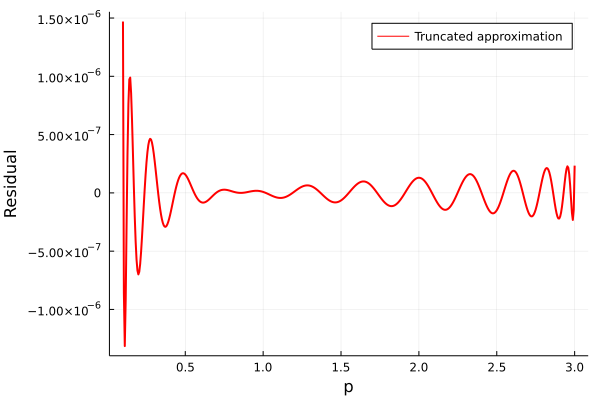

In [49]:
using Plots;
Plots.plot(ps_grid, resids_trunc, color = :red, linewidth = 2.0, label="Truncated approximation", xlabel = "p", ylabel="Residual")

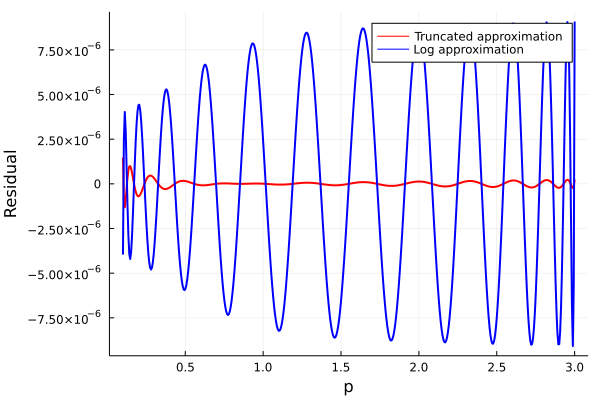

In [50]:
Plots.plot!(ps_grid, resids_log, color = :blue, linewidth = 2.0, label="Log approximation")

So the truncated approximation seems to work better for us here

Let's take a look on the approximated functions now. We need to evaluate $\hat{S}$ using our solution coefficients

In [66]:
S_hat_trunc = max.(0.0, eval_chebpoly(c_trunc, n, a, b, ps_grid));
S_hat_log = exp.(eval_chebpoly(c_log, n, a, b, ps_grid));

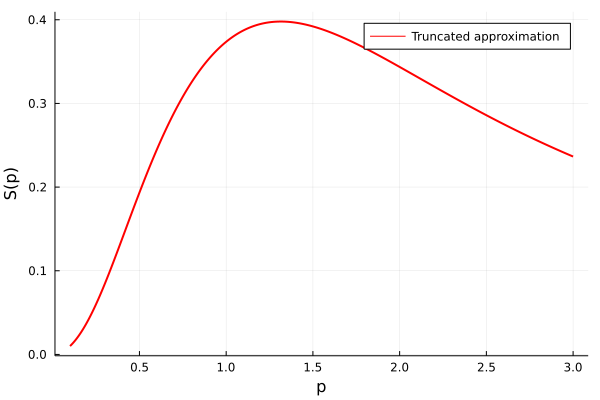

In [52]:
Plots.plot(ps_grid, S_hat_trunc, color = :red, linewidth = 2.0, label="Truncated approximation", xlabel = "p", ylabel="S(p)")

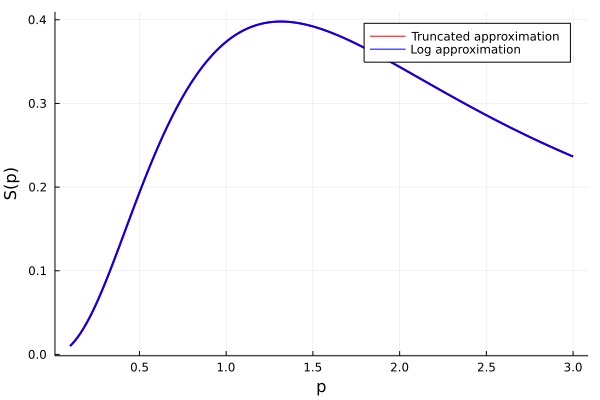

In [53]:
Plots.plot!(ps_grid, S_hat_log, color = :blue, linewidth = 2.0, label="Log approximation")

Since the errors are pretty small, these functions are visually identical

Using the fact that aggregate supply is $mS(p)$, we can now plot a demand-supply graph for multiple numbers of firms

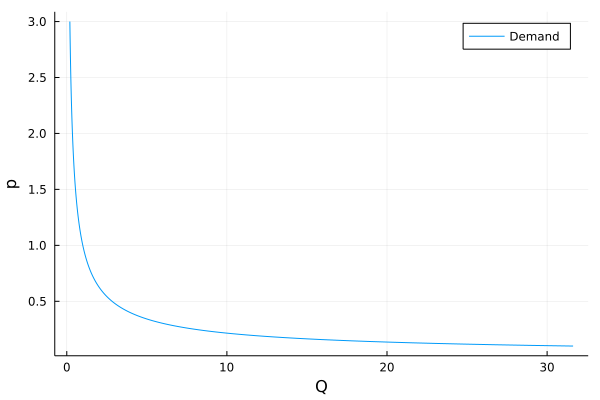

In [59]:
D(p) = p^(-η);
ds = D.(ps_grid);
Plots.plot(ds, ps_grid, linewidth = 1.0, label="Demand", xlabel = "Q", ylabel="p")

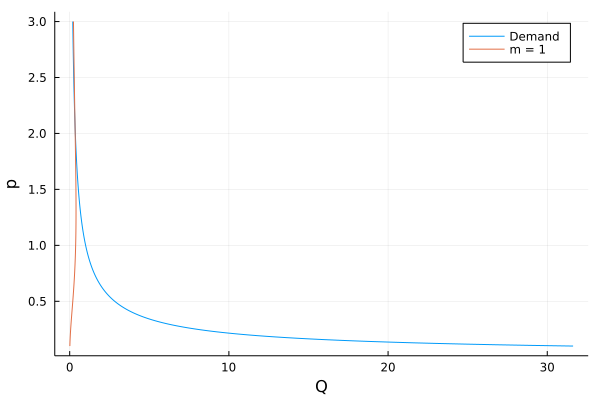

In [60]:
Plots.plot!(S_hat_trunc, ps_grid, linewidth = 1.0, label="m = 1")

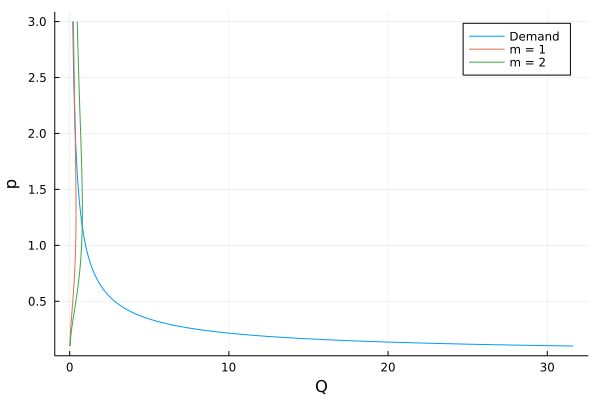

In [61]:
Plots.plot!(S_hat_trunc .* 2, ps_grid, linewidth = 1.0, label="m = 2")

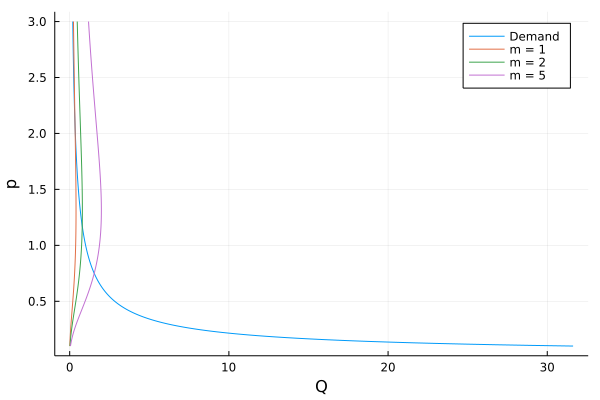

In [62]:
Plots.plot!(S_hat_trunc .* 5, ps_grid, linewidth = 1.0, label="m = 5")

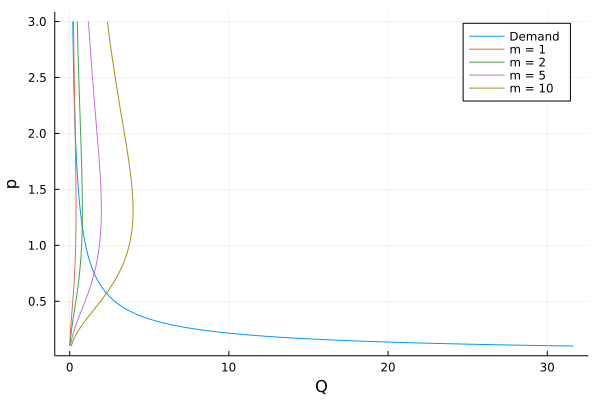

In [63]:
Plots.plot!(S_hat_trunc .* 10, ps_grid, linewidth = 1.0, label="m = 10")

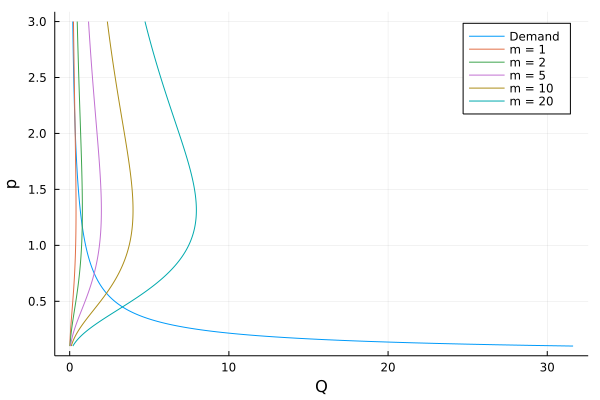

In [64]:
Plots.plot!(S_hat_trunc .* 20, ps_grid, linewidth = 1.0, label="m = 20")

The intersections between supply and demand curves give the equilibrium in each case
- And we could use a nonlinear rootfinding method to solve for the equilibrium $D - \hat{S} = 0$